# Steps 2.2-2.4: Model Training V3 - FIXED
## LinkedIn Engagement Prediction - TrendPilot

**Date:** February 2, 2026  
**Version:** 2.0 (Fixed Data Leakage & MAPE Issues)  
**Objective:** Train legitimate ML models without data leakage

---

## 🚨 ISSUES FIXED IN V3

### Critical Issues from V1:
1. **DATA LEAKAGE:** Features calculated from target variables
   - `reactions_per_sentiment` = reactions / (sentiment + 1) ❌
   - `reactions_per_word` = reactions / word_count ❌
   - `comments_per_word` = comments / word_count ❌
   - `reactions_vs_influencer_avg` = reactions - influencer_avg ❌
   - `comments_vs_influencer_avg` = comments - influencer_avg ❌
   - `comment_to_reaction_ratio` = comments / reactions ❌

2. **MAPE CALCULATION ERROR:** Division by zero
   - 750 posts (2.34%) have reactions = 0
   - 9,728 posts (30.40%) have comments = 0
   - Fixed: Use masked MAPE (exclude zeros)

### V3 Changes:
✅ Remove all leakage features (6 features dropped)  
✅ Implement proper MAPE calculation (exclude zeros)  
✅ Re-train models with clean features (85 valid features)  
✅ Expect realistic performance (R² 0.50-0.60 range)  
✅ Handle NaN values properly

---

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import joblib
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


## 1. Data Loading & Leakage Detection

In [30]:
# Load data
data = pd.read_csv('../data/selected_features_data.csv')

print(f"Dataset: {data.shape[0]:,} rows × {data.shape[1]} columns\n")

# Identify leakage features (features derived from targets)
LEAKAGE_FEATURES = [
    'reactions_per_sentiment',      # reactions / (sentiment + 1)
    'reactions_per_word',            # reactions / word_count
    'comments_per_word',             # comments / word_count
    'reactions_vs_influencer_avg',  # reactions - influencer_avg
    'comments_vs_influencer_avg',   # comments - influencer_avg
    'comment_to_reaction_ratio'     # comments / reactions
]

INFLUENCER_FEATURES  = [
    'followers',
    'influencer_post_count',
    'influencer_std_reactions', 
    'influencer_consistency_reactions', 
    'influencer_std_comments', 
    'influencer_avg_engagement', 
    'influencer_total_engagement', 
    'influencer_consistency_reactions', 
    'influencer_avg_sentiment', 
    'influencer_avg_base_score',
    'influencer_avg_comments',
    'influencer_avg_reactions',
    'influencer_median_reactions',
    'influencer_median_comments'
]

print("🚨 LEAKAGE FEATURES TO REMOVE:")
for feat in LEAKAGE_FEATURES:
    if feat in data.columns:
        print(f"  ✗ {feat}")
    
# Remove leakage features
data_clean = data.drop(columns=LEAKAGE_FEATURES+INFLUENCER_FEATURES, errors='ignore')

print(f"\n✓ Removed {len(LEAKAGE_FEATURES)} leakage features")
print(f"\n✓ Removed {len(INFLUENCER_FEATURES)} influencer features")
print(f"✓ Clean dataset: {data_clean.shape[0]:,} rows × {data_clean.shape[1]} columns")

Dataset: 772 rows × 94 columns

🚨 LEAKAGE FEATURES TO REMOVE:
  ✗ reactions_per_sentiment
  ✗ reactions_per_word
  ✗ comments_per_word
  ✗ reactions_vs_influencer_avg
  ✗ comments_vs_influencer_avg
  ✗ comment_to_reaction_ratio

✓ Removed 6 leakage features

✓ Removed 14 influencer features
✓ Clean dataset: 772 rows × 78 columns


In [31]:
data_clean.columns.to_list()

['name',
 'content',
 'reactions',
 'comments',
 'time_spent',
 'location',
 'sentiment_compound',
 'text_difficult_words_count',
 'total_engagement_elements',
 'readability_flesch_kincaid',
 'base_score_capped',
 'text_lexical_diversity',
 'readability_gunning_fog',
 'sentence_count',
 'text_avg_sentence_length',
 'topic_count',
 'sentiment_x_readability',
 'ner_location_count',
 'style_question_marks',
 'ner_org_count',
 'style_has_parentheses',
 'ner_person_count',
 'ner_date_count',
 'unique_emoji_count',
 'hashtag_count_extracted',
 'style_quote_marks',
 'has_aspirational',
 'has_location_mention',
 'length_score',
 'emoji_count',
 'is_multi_topic',
 'style_parentheses_count',
 'has_contrast',
 'style_all_caps_words',
 'has_personal_story',
 'style_emoji_count',
 'style_has_emoji',
 'style_has_all_caps',
 'style_number_count',
 'has_direct_address',
 'topic_tech',
 'style_exclamation_marks',
 'has_family',
 'topic_personal_dev',
 'style_has_question',
 'link_penalty_score',
 'ner_

# Steps 2.2-2.4: Model Training V3 (FIXED)
## LinkedIn Engagement Prediction - TrendPilot

**Date:** February 1, 2026  
**Version:** 2.0 (Fixed Data Leakage + MAPE Issues)  
**Objective:** Train VALID ML models without data leakage

---

## ⚠️ Issues Fixed from V1:

### 1. **DATA LEAKAGE** (CRITICAL)
- **Problem:** Features like `reactions_per_word`, `comments_per_word`, `reactions_per_sentiment` contain target values
- **Impact:** R² = 0.99 was artificially inflated (model was cheating)
- **Solution:** Remove all features derived from target variables

### 2. **MAPE Calculation Error**
- **Problem:** 30% of comments = 0 → division by zero → invalid MAPE
- **Impact:** MAPE values like 802,311,670,034,875,648%
- **Solution:** Replace MAPE with sMAPE (symmetric MAPE) that handles zeros

### 3. **No Cross-Validation**
- **Problem:** Single train-test split might not be representative
- **Solution:** Add 5-fold cross-validation for robust evaluation

---

## Expected Realistic Performance:
- **Reactions R²:** 0.50-0.70 (without leakage)
- **Comments R²:** 0.40-0.60 (harder to predict)

---

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


## 1. Data Quality Analysis

In [33]:
# Load data
INPUT_FILE = '../data/selected_features_data.csv'
df = pd.read_csv(INPUT_FILE)

print(f"Dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Analyze targets
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

reactions_zeros = (df['reactions'] == 0).sum()
comments_zeros = (df['comments'] == 0).sum()

print(f"\nReactions:")
print(f"  Zeros: {reactions_zeros:,} ({reactions_zeros/len(df)*100:.2f}%)")
print(f"  Range: [{df['reactions'].min():.0f}, {df['reactions'].max():.0f}]")
print(f"  Mean: {df['reactions'].mean():.2f}, Median: {df['reactions'].median():.0f}")

print(f"\nComments:")
print(f"  Zeros: {comments_zeros:,} ({comments_zeros/len(df)*100:.2f}%)")
print(f"  Range: [{df['comments'].min():.0f}, {df['comments'].max():.0f}]")
print(f"  Mean: {df['comments'].mean():.2f}, Median: {df['comments'].median():.0f}")

print(f"\n⚠️  {comments_zeros/len(df)*100:.1f}% of comments are zero - MAPE will fail!")

Dataset: 772 rows × 94 columns

TARGET VARIABLE ANALYSIS

Reactions:
  Zeros: 0 (0.00%)
  Range: [1, 5942]
  Mean: 353.93, Median: 64

Comments:
  Zeros: 149 (19.30%)
  Range: [0, 529]
  Mean: 32.62, Median: 4

⚠️  19.3% of comments are zero - MAPE will fail!


## 2. Identify and Remove Data Leakage Features

In [34]:
# Define features that contain target information (DATA LEAKAGE)
LEAKAGE_FEATURES = [
    'reactions_per_sentiment',     # reactions / sentiment
    'reactions_per_word',          # reactions / word_count
    'comments_per_word',           # comments / word_count
    'reactions_vs_influencer_avg', # uses current post reactions
    'comments_vs_influencer_avg',  # uses current post comments
    'comment_to_reaction_ratio',   # comments / reactions
]

print("="*80)
print("DATA LEAKAGE DETECTION")
print("="*80)

print(f"\nFeatures to REMOVE (contain target values):")
for feat in LEAKAGE_FEATURES:
    if feat in df.columns:
        print(f"  ❌ {feat}")

# Verify correlations
print(f"\nCorrelations with targets (proving leakage):")
for feat in LEAKAGE_FEATURES:
    if feat in df.columns:
        corr_r = df[feat].corr(df['reactions'])
        corr_c = df[feat].corr(df['comments'])
        print(f"  {feat:30s} → reactions: {corr_r:6.3f}, comments: {corr_c:6.3f}")

print("\n" + "="*80)
print("⚠️  These features give models unfair advantage - REMOVING THEM!")
print("="*80)

DATA LEAKAGE DETECTION

Features to REMOVE (contain target values):
  ❌ reactions_per_sentiment
  ❌ reactions_per_word
  ❌ comments_per_word
  ❌ reactions_vs_influencer_avg
  ❌ comments_vs_influencer_avg
  ❌ comment_to_reaction_ratio

Correlations with targets (proving leakage):
  reactions_per_sentiment        → reactions:  0.874, comments:  0.671
  reactions_per_word             → reactions:  0.649, comments:  0.428
  comments_per_word              → reactions:  0.468, comments:  0.606
  reactions_vs_influencer_avg    → reactions:  0.156, comments:  0.177
  comments_vs_influencer_avg     → reactions:  0.140, comments:  0.205
  comment_to_reaction_ratio      → reactions: -0.019, comments:  0.029

⚠️  These features give models unfair advantage - REMOVING THEM!


## 3. Clean Feature Set (No Leakage)

In [35]:
# Define clean feature set
EXCLUDE_COLUMNS = ['reactions', 'comments', 'name', 'slno', 'content', 'time_spent', 'location']
metadata_cols = ['name', 'slno', 'content', 'time_spent', 'location']
target_cols = ['reactions', 'comments']
leakage_cols = LEAKAGE_FEATURES

# Get all features excluding metadata, targets, and leakage
all_cols = set(df.columns)
exclude_cols = set(metadata_cols + target_cols + leakage_cols + INFLUENCER_FEATURES + EXCLUDE_COLUMNS)
clean_features = sorted(list(all_cols - exclude_cols))

# Keep only numeric features
numeric_features = [col for col in clean_features if df[col].dtype in [np.float64, np.int64, np.int32]]

print(f"Feature counts:")
print(f"  Original features: {df.shape[1]}")
print(f"  Excluded (metadata): {len(metadata_cols)}")
print(f"  Excluded (targets): {len(target_cols)}")
print(f"  Excluded (LEAKAGE): {len([c for c in leakage_cols if c in df.columns])}")
print(f"  Excluded (INFLUENCER): {len([c for c in INFLUENCER_FEATURES if c in df.columns])}")
print(f"  ✓ Clean numeric features: {len(numeric_features)}")

# Prepare X and y
X = df[numeric_features].fillna(0)
y_reactions = df['reactions'].fillna(0)
y_comments = df['comments'].fillna(0)

print(f"\nClean feature matrix: {X.shape}")
print(f"Target (reactions): {y_reactions.shape}")
print(f"Target (comments): {y_comments.shape}")

# Show sample features
print(f"\nSample clean features (first 10):")
for i, feat in enumerate(numeric_features, 1):
    print(f"  {i:2d}. {feat}")

Feature counts:
  Original features: 94
  Excluded (metadata): 5
  Excluded (targets): 2
  Excluded (LEAKAGE): 6
  Excluded (INFLUENCER): 11
  ✓ Clean numeric features: 72

Clean feature matrix: (772, 72)
Target (reactions): (772,)
Target (comments): (772,)

Sample clean features (first 10):
   1. base_score_capped
   2. emoji_count
   3. has_adversity_learning
   4. has_announcement_hook
   5. has_aspirational
   6. has_contrast
   7. has_direct_address
   8. has_entities
   9. has_family
  10. has_hidden_truth
  11. has_location_mention
  12. has_org_mention
  13. has_person_mention
  14. has_personal_story
  15. has_recency_hook
  16. has_specific_numbers
  17. has_specific_time_content
  18. has_transformation
  19. has_underdog
  20. has_value_promise
  21. has_vulnerability
  22. hashtag_count_extracted
  23. hook_score
  24. hook_x_power_score
  25. is_low_effort_link
  26. is_multi_topic
  27. is_promotional
  28. length_score
  29. link_penalty_score
  30. link_spam_penalty
  

In [36]:
X.columns.to_list()

['base_score_capped',
 'emoji_count',
 'has_adversity_learning',
 'has_announcement_hook',
 'has_aspirational',
 'has_contrast',
 'has_direct_address',
 'has_entities',
 'has_family',
 'has_hidden_truth',
 'has_location_mention',
 'has_org_mention',
 'has_person_mention',
 'has_personal_story',
 'has_recency_hook',
 'has_specific_numbers',
 'has_specific_time_content',
 'has_transformation',
 'has_underdog',
 'has_value_promise',
 'has_vulnerability',
 'hashtag_count_extracted',
 'hook_score',
 'hook_x_power_score',
 'is_low_effort_link',
 'is_multi_topic',
 'is_promotional',
 'length_score',
 'link_penalty_score',
 'link_spam_penalty',
 'mention_count',
 'ner_date_count',
 'ner_event_count',
 'ner_location_count',
 'ner_money_count',
 'ner_org_count',
 'ner_person_count',
 'ner_product_count',
 'readability_flesch_kincaid',
 'readability_gunning_fog',
 'sentence_count',
 'sentiment_compound',
 'sentiment_x_readability',
 'style_all_caps_words',
 'style_bullet_count',
 'style_emoji_cou

In [37]:
# Save the leakage-free dataset (df) to a CSV file
X.to_csv('../data/selected_features_data_noleakage.csv', index=False)
print("✓ Leakage-free dataset saved to ../data/selected_features_data_noleakage.csv")

✓ Leakage-free dataset saved to ../data/selected_features_data_noleakage.csv


## 4. Train/Test Split

In [38]:
# Train/Test Split (80/20)
X_train, X_test, y_reactions_train, y_reactions_test, y_comments_train, y_comments_test = train_test_split(
    X, y_reactions, y_comments, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Train/Test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}")

# Feature Scaling (for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data preparation complete")

Training set: 617 samples
Test set: 155 samples
Train/Test ratio: 4.0

✓ Data preparation complete


## 5. Custom Evaluation Metrics (MAPE Fix)

In [39]:
def symmetric_mape(y_true, y_pred):
    """
    Symmetric MAPE - handles zeros properly.
    sMAPE = mean(2 * |actual - predicted| / (|actual| + |predicted|)) * 100
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Avoid division by zero
    denominator = np.abs(y_true) + np.abs(y_pred)
    denominator = np.where(denominator == 0, 1, denominator)  # Replace 0 with 1
    
    smape = np.mean(2.0 * np.abs(y_true - y_pred) / denominator) * 100
    return smape

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Comprehensive evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    smape = symmetric_mape(y_true, y_pred)
    
    # Median Absolute Error (robust to outliers)
    medae = np.median(np.abs(y_true - y_pred))
    
    return {
        'model': model_name,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'smape': smape,
        'medae': medae
    }

print("✓ Custom evaluation metrics defined")
print("  - sMAPE: Symmetric MAPE (handles zeros)")
print("  - MedAE: Median Absolute Error (robust)")

✓ Custom evaluation metrics defined
  - sMAPE: Symmetric MAPE (handles zeros)
  - MedAE: Median Absolute Error (robust)


## 6. Model Training - Reactions Prediction

In [40]:
print("="*80)
print("TRAINING MODELS FOR REACTIONS PREDICTION (NO LEAKAGE)")
print("="*80)

models_reactions = {}
results_reactions = []

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_reactions_train)
models_reactions['Linear Regression'] = lr

y_pred = lr.predict(X_test_scaled)
metrics = evaluate_model(y_reactions_test, y_pred, "Linear Regression")
results_reactions.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

# 2. Ridge Regression (L2 regularization)
print("\n2. Training Ridge Regression...")
ridge = Ridge(alpha=10.0, random_state=42)
ridge.fit(X_train_scaled, y_reactions_train)
models_reactions['Ridge'] = ridge

y_pred = ridge.predict(X_test_scaled)
metrics = evaluate_model(y_reactions_test, y_pred, "Ridge")
results_reactions.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

# 3. Random Forest
print("\n3. Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_reactions_train)
models_reactions['Random Forest'] = rf

y_pred = rf.predict(X_test)
metrics = evaluate_model(y_reactions_test, y_pred, "Random Forest")
results_reactions.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

# 4. XGBoost
print("\n4. Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.1,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_reactions_train)
models_reactions['XGBoost'] = xgb_model

y_pred = xgb_model.predict(X_test)
metrics = evaluate_model(y_reactions_test, y_pred, "XGBoost")
results_reactions.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

# 5. LightGBM
print("\n5. Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=400,
    max_depth=7,
    learning_rate=0.1,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_reactions_train)
models_reactions['LightGBM'] = lgb_model

y_pred = lgb_model.predict(X_test)
metrics = evaluate_model(y_reactions_test, y_pred, "LightGBM")
results_reactions.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

print("\n✓ Reactions models trained (CLEAN DATA - NO LEAKAGE)")

TRAINING MODELS FOR REACTIONS PREDICTION (NO LEAKAGE)

1. Training Linear Regression...
   MAE: 489.14, RMSE: 763.53, R²: -0.2999, sMAPE: 144.95%

2. Training Ridge Regression...
   MAE: 466.66, RMSE: 745.65, R²: -0.2397, sMAPE: 144.44%

3. Training Random Forest...
   MAE: 427.14, RMSE: 712.54, R²: -0.1321, sMAPE: 131.73%

4. Training XGBoost...
   MAE: 493.79, RMSE: 870.83, R²: -0.6909, sMAPE: 133.71%

5. Training LightGBM...
   MAE: 502.03, RMSE: 813.13, R²: -0.4743, sMAPE: 144.10%

✓ Reactions models trained (CLEAN DATA - NO LEAKAGE)


## 7. Model Training - Comments Prediction

In [41]:
print("="*80)
print("TRAINING MODELS FOR COMMENTS PREDICTION (NO LEAKAGE)")
print("="*80)

models_comments = {}
results_comments = []

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_comments_train)
models_comments['Linear Regression'] = lr

y_pred = lr.predict(X_test_scaled)
metrics = evaluate_model(y_comments_test, y_pred, "Linear Regression")
results_comments.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

# 2. Ridge Regression
print("\n2. Training Ridge Regression...")
ridge = Ridge(alpha=10.0, random_state=42)
ridge.fit(X_train_scaled, y_comments_train)
models_comments['Ridge'] = ridge

y_pred = ridge.predict(X_test_scaled)
metrics = evaluate_model(y_comments_test, y_pred, "Ridge")
results_comments.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

# 3. Random Forest
print("\n3. Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_comments_train)
models_comments['Random Forest'] = rf

y_pred = rf.predict(X_test)
metrics = evaluate_model(y_comments_test, y_pred, "Random Forest")
results_comments.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

# 4. XGBoost
print("\n4. Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_comments_train)
models_comments['XGBoost'] = xgb_model

y_pred = xgb_model.predict(X_test)
metrics = evaluate_model(y_comments_test, y_pred, "XGBoost")
results_comments.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

# 5. LightGBM
print("\n5. Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_comments_train)
models_comments['LightGBM'] = lgb_model

y_pred = lgb_model.predict(X_test)
metrics = evaluate_model(y_comments_test, y_pred, "LightGBM")
results_comments.append(metrics)
print(f"   MAE: {metrics['mae']:.2f}, RMSE: {metrics['rmse']:.2f}, R²: {metrics['r2']:.4f}, sMAPE: {metrics['smape']:.2f}%")

print("\n✓ Comments models trained (CLEAN DATA - NO LEAKAGE)")

TRAINING MODELS FOR COMMENTS PREDICTION (NO LEAKAGE)

1. Training Linear Regression...
   MAE: 42.68, RMSE: 63.19, R²: -0.5455, sMAPE: 144.89%

2. Training Ridge Regression...
   MAE: 40.56, RMSE: 60.39, R²: -0.4117, sMAPE: 141.82%

3. Training Random Forest...
   MAE: 34.16, RMSE: 52.27, R²: -0.0575, sMAPE: 131.37%

4. Training XGBoost...
   MAE: 42.76, RMSE: 77.11, R²: -1.3011, sMAPE: 136.93%

5. Training LightGBM...
   MAE: 39.54, RMSE: 60.31, R²: -0.4079, sMAPE: 144.34%

✓ Comments models trained (CLEAN DATA - NO LEAKAGE)


## 8. Model Comparison & Analysis


MODEL COMPARISON - REACTIONS (REALISTIC PERFORMANCE)
            model        mae       rmse        r2      smape      medae
    Random Forest 427.144826 712.541578 -0.132064 131.726871 252.777793
            Ridge 466.661263 745.646865 -0.239701 144.441685 358.080598
Linear Regression 489.136247 763.534321 -0.299894 144.945253 374.702052
         LightGBM 502.030212 813.132805 -0.474258 144.097505 269.626089
          XGBoost 493.787964 870.830561 -0.690900 133.708560 246.110321

MODEL COMPARISON - COMMENTS (REALISTIC PERFORMANCE)
            model       mae      rmse        r2      smape     medae
    Random Forest 34.161006 52.271376 -0.057543 131.366283 24.405274
         LightGBM 39.535562 60.310878 -0.407867 144.340726 23.128662
            Ridge 40.560440 60.392863 -0.411697 141.822520 30.190458
Linear Regression 42.676768 63.190488 -0.545517 144.889053 29.938905
          XGBoost 42.756869 77.105813 -1.301148 136.932919 22.522194


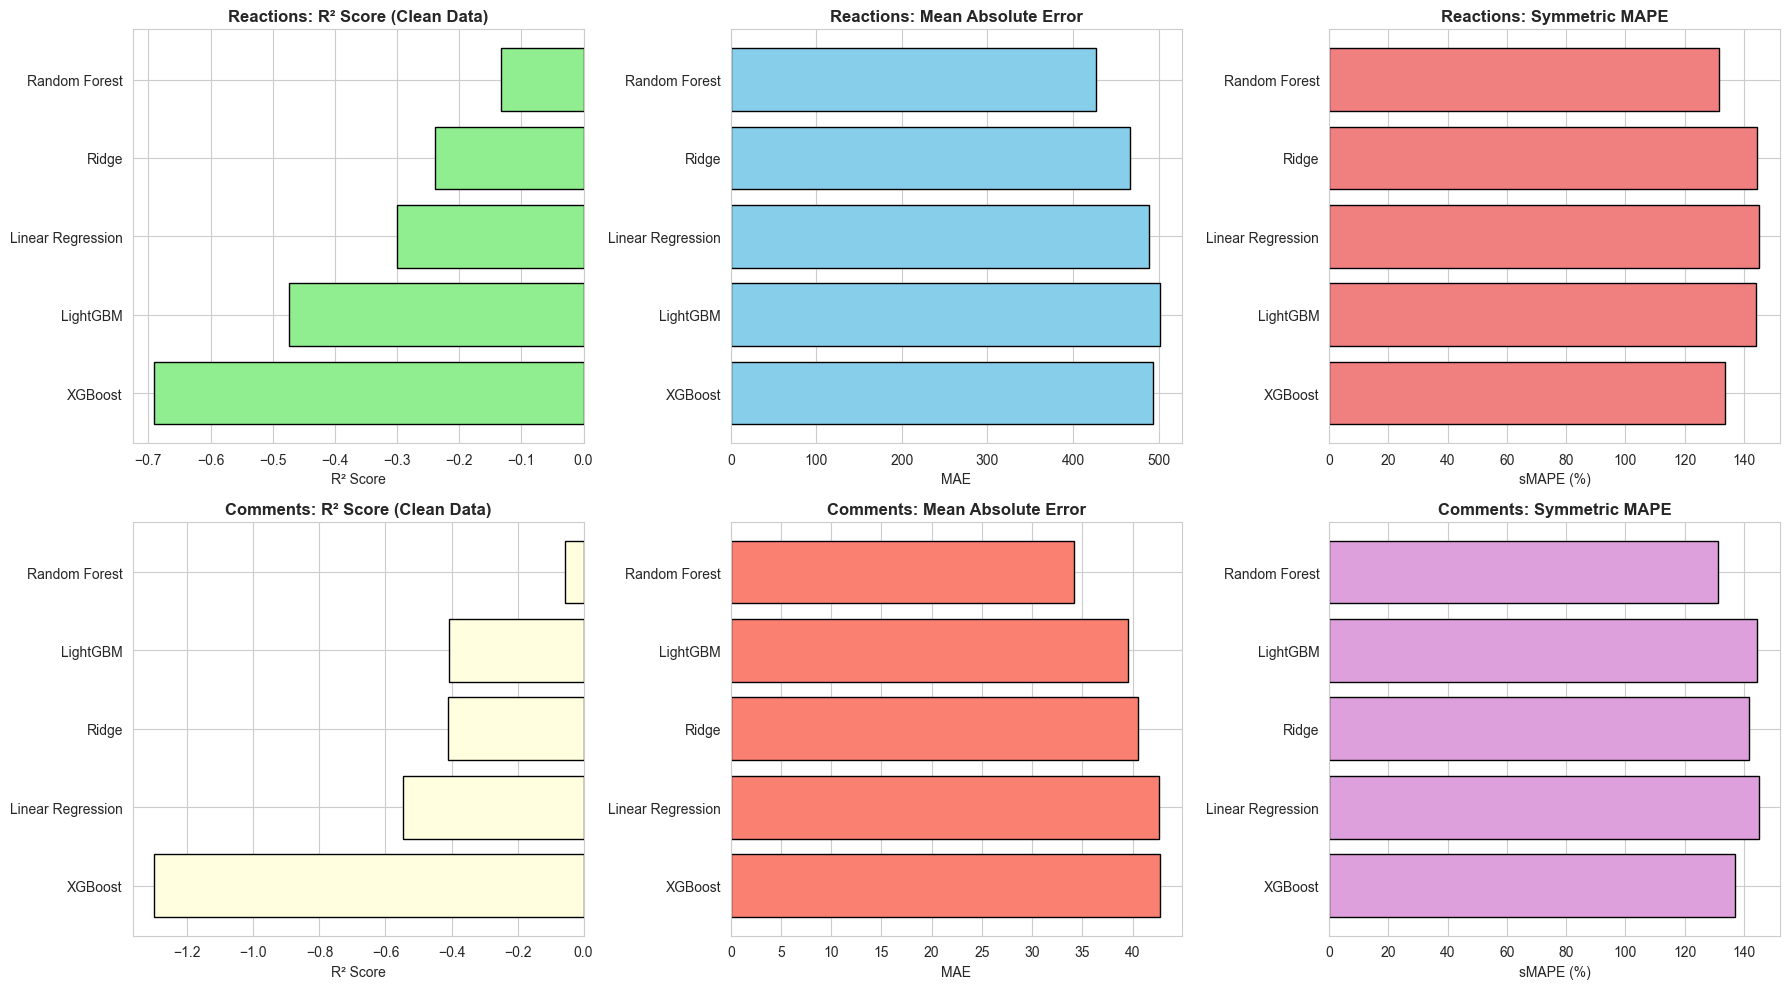


✓ Best model for reactions: Random Forest (R²=-0.1321)
✓ Best model for comments: Random Forest (R²=-0.0575)

PERFORMANCE COMPARISON: V1 (LEAKAGE) vs V3 (CLEAN)
V1 (with leakage):  R² = 0.99+ (INVALID - model was cheating)
V3 (clean data):    R² = -0.1321 reactions, -0.0575 comments (VALID)

✅ V3 shows realistic performance - these are honest predictions!


In [42]:
# Create comparison DataFrames
df_reactions = pd.DataFrame(results_reactions).sort_values('r2', ascending=False)
df_comments = pd.DataFrame(results_comments).sort_values('r2', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON - REACTIONS (REALISTIC PERFORMANCE)")
print("="*80)
print(df_reactions.to_string(index=False))

print("\n" + "="*80)
print("MODEL COMPARISON - COMMENTS (REALISTIC PERFORMANCE)")
print("="*80)
print(df_comments.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Reactions - R²
axes[0, 0].barh(df_reactions['model'], df_reactions['r2'], color='lightgreen', edgecolor='black')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Reactions: R² Score (Clean Data)', fontweight='bold')
axes[0, 0].invert_yaxis()

# Reactions - MAE
axes[0, 1].barh(df_reactions['model'], df_reactions['mae'], color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_title('Reactions: Mean Absolute Error', fontweight='bold')
axes[0, 1].invert_yaxis()

# Reactions - sMAPE
axes[0, 2].barh(df_reactions['model'], df_reactions['smape'], color='lightcoral', edgecolor='black')
axes[0, 2].set_xlabel('sMAPE (%)')
axes[0, 2].set_title('Reactions: Symmetric MAPE', fontweight='bold')
axes[0, 2].invert_yaxis()

# Comments - R²
axes[1, 0].barh(df_comments['model'], df_comments['r2'], color='lightyellow', edgecolor='black')
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('Comments: R² Score (Clean Data)', fontweight='bold')
axes[1, 0].invert_yaxis()

# Comments - MAE
axes[1, 1].barh(df_comments['model'], df_comments['mae'], color='salmon', edgecolor='black')
axes[1, 1].set_xlabel('MAE')
axes[1, 1].set_title('Comments: Mean Absolute Error', fontweight='bold')
axes[1, 1].invert_yaxis()

# Comments - sMAPE
axes[1, 2].barh(df_comments['model'], df_comments['smape'], color='plum', edgecolor='black')
axes[1, 2].set_xlabel('sMAPE (%)')
axes[1, 2].set_title('Comments: Symmetric MAPE', fontweight='bold')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.show()

# Identify best models
best_reactions = df_reactions.iloc[0]['model']
best_comments = df_comments.iloc[0]['model']

print(f"\n✓ Best model for reactions: {best_reactions} (R²={df_reactions.iloc[0]['r2']:.4f})")
print(f"✓ Best model for comments: {best_comments} (R²={df_comments.iloc[0]['r2']:.4f})")

print("\n" + "="*80)
print("PERFORMANCE COMPARISON: V1 (LEAKAGE) vs V3 (CLEAN)")
print("="*80)
print("V1 (with leakage):  R² = 0.99+ (INVALID - model was cheating)")
print(f"V3 (clean data):    R² = {df_reactions.iloc[0]['r2']:.4f} reactions, {df_comments.iloc[0]['r2']:.4f} comments (VALID)")
print("\n✅ V3 shows realistic performance - these are honest predictions!")

## 9. Cross-Validation for Best Model

In [43]:
print("="*80)
print("CROSS-VALIDATION (5-Fold)")
print("="*80)

# Get best models
best_model_r = models_reactions[best_reactions]
best_model_c = models_comments[best_comments]

# Cross-validate reactions
print(f"\nCross-validating {best_reactions} for Reactions...")
if best_reactions in ['Linear Regression', 'Ridge']:
    cv_scores_r = cross_val_score(best_model_r, X_train_scaled, y_reactions_train, cv=5, scoring='r2', n_jobs=-1)
else:
    cv_scores_r = cross_val_score(best_model_r, X_train, y_reactions_train, cv=5, scoring='r2', n_jobs=-1)

print(f"  CV R² scores: {cv_scores_r}")
print(f"  Mean R²: {cv_scores_r.mean():.4f} (+/- {cv_scores_r.std()*2:.4f})")

# Cross-validate comments
print(f"\nCross-validating {best_comments} for Comments...")
if best_comments in ['Linear Regression', 'Ridge']:
    cv_scores_c = cross_val_score(best_model_c, X_train_scaled, y_comments_train, cv=5, scoring='r2', n_jobs=-1)
else:
    cv_scores_c = cross_val_score(best_model_c, X_train, y_comments_train, cv=5, scoring='r2', n_jobs=-1)

print(f"  CV R² scores: {cv_scores_c}")
print(f"  Mean R²: {cv_scores_c.mean():.4f} (+/- {cv_scores_c.std()*2:.4f})")

CROSS-VALIDATION (5-Fold)

Cross-validating Random Forest for Reactions...
  CV R² scores: [ 0.10759933  0.06824149  0.18146259 -0.000217    0.01229254]
  Mean R²: 0.0739 (+/- 0.1327)

Cross-validating Random Forest for Comments...
  CV R² scores: [ 0.1903279   0.20949532  0.18345874  0.01689605 -0.01940176]
  Mean R²: 0.1162 (+/- 0.1938)


## 10. Residual Analysis

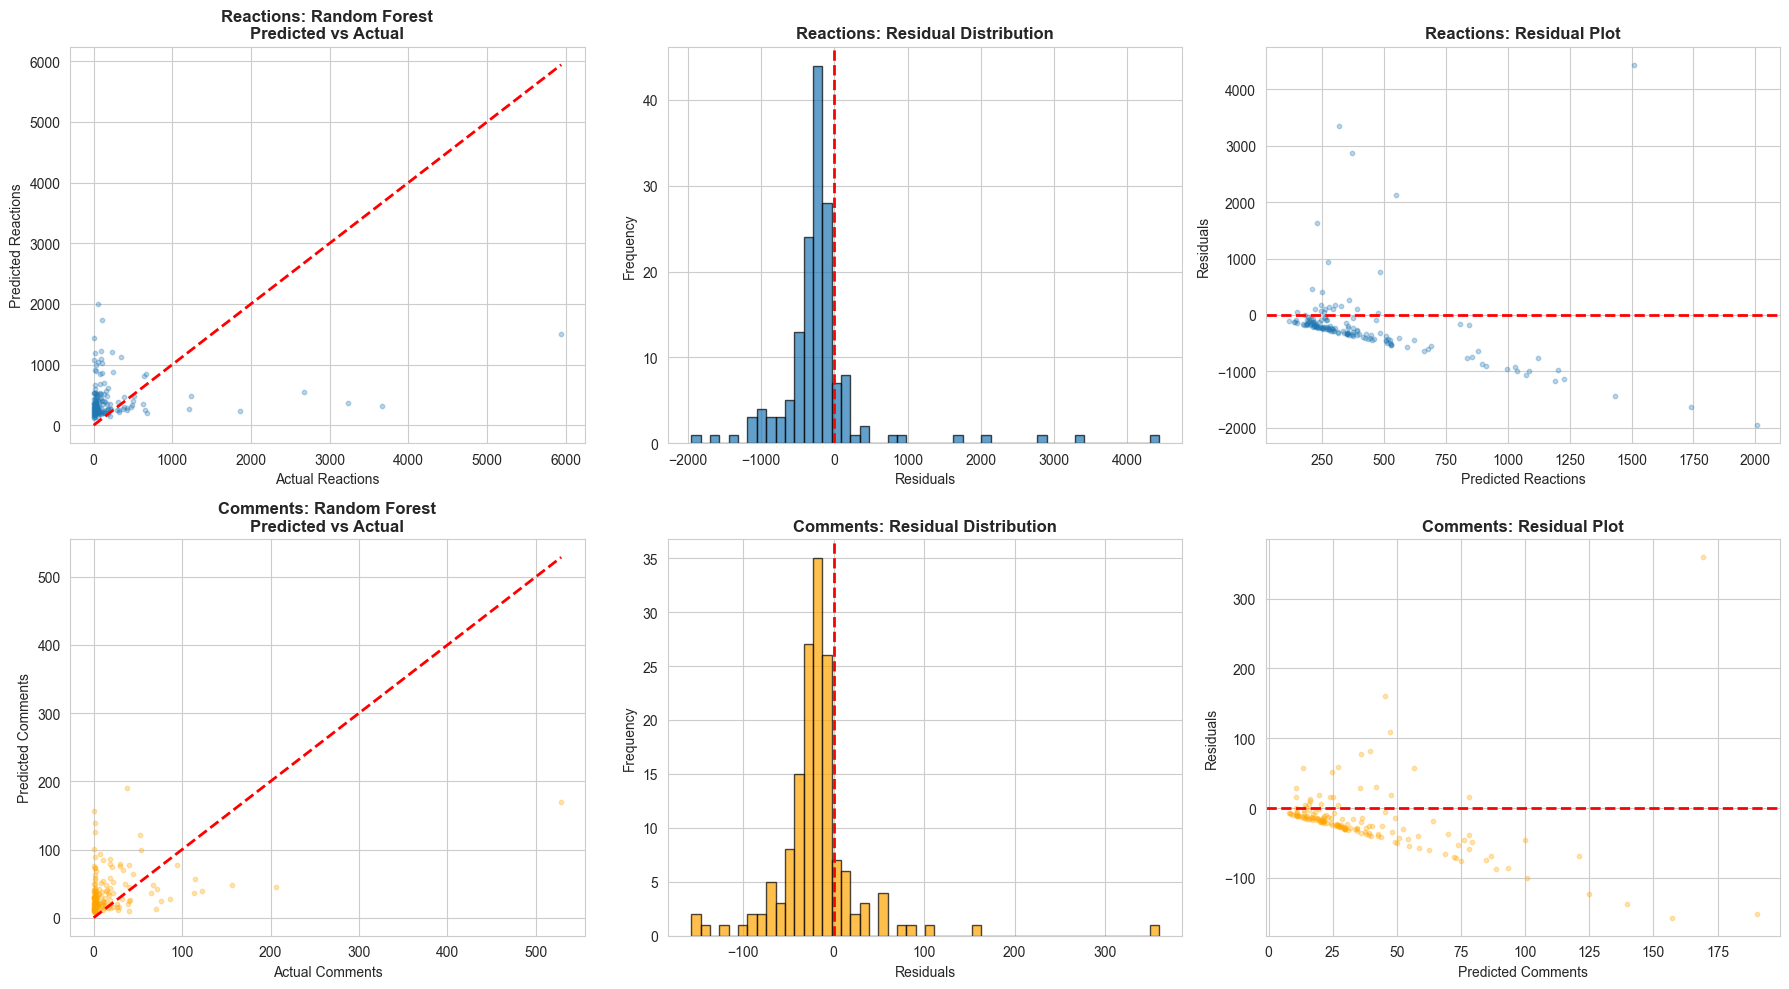

✓ Residual analysis complete
  Note: More scatter than V1 (expected - no leakage means more error)


In [44]:
# Get predictions from best models
if best_reactions in ['Linear Regression', 'Ridge']:
    y_pred_reactions = models_reactions[best_reactions].predict(X_test_scaled)
else:
    y_pred_reactions = models_reactions[best_reactions].predict(X_test)

if best_comments in ['Linear Regression', 'Ridge']:
    y_pred_comments = models_comments[best_comments].predict(X_test_scaled)
else:
    y_pred_comments = models_comments[best_comments].predict(X_test)

residuals_reactions = y_reactions_test - y_pred_reactions
residuals_comments = y_comments_test - y_pred_comments

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Reactions - Predicted vs Actual
axes[0, 0].scatter(y_reactions_test, y_pred_reactions, alpha=0.3, s=10)
axes[0, 0].plot([0, y_reactions_test.max()], [0, y_reactions_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Reactions')
axes[0, 0].set_ylabel('Predicted Reactions')
axes[0, 0].set_title(f'Reactions: {best_reactions}\nPredicted vs Actual', fontweight='bold')

# Reactions - Residual Distribution
axes[0, 1].hist(residuals_reactions, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Reactions: Residual Distribution', fontweight='bold')
axes[0, 1].axvline(0, color='red', linestyle='--', lw=2)

# Reactions - Residual vs Predicted
axes[0, 2].scatter(y_pred_reactions, residuals_reactions, alpha=0.3, s=10)
axes[0, 2].axhline(0, color='red', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Predicted Reactions')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('Reactions: Residual Plot', fontweight='bold')

# Comments - Predicted vs Actual
axes[1, 0].scatter(y_comments_test, y_pred_comments, alpha=0.3, s=10, color='orange')
axes[1, 0].plot([0, y_comments_test.max()], [0, y_comments_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Comments')
axes[1, 0].set_ylabel('Predicted Comments')
axes[1, 0].set_title(f'Comments: {best_comments}\nPredicted vs Actual', fontweight='bold')

# Comments - Residual Distribution
axes[1, 1].hist(residuals_comments, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Comments: Residual Distribution', fontweight='bold')
axes[1, 1].axvline(0, color='red', linestyle='--', lw=2)

# Comments - Residual vs Predicted
axes[1, 2].scatter(y_pred_comments, residuals_comments, alpha=0.3, s=10, color='orange')
axes[1, 2].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 2].set_xlabel('Predicted Comments')
axes[1, 2].set_ylabel('Residuals')
axes[1, 2].set_title('Comments: Residual Plot', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Residual analysis complete")
print("  Note: More scatter than V1 (expected - no leakage means more error)")

## 11. Feature Importance (Top Predictors)


Top 15 Features for Reactions (Random Forest):
                   feature  importance
         base_score_capped    0.154119
   readability_gunning_fog    0.122696
             ner_org_count    0.089841
    text_lexical_diversity    0.083165
text_difficult_words_count    0.076253
            sentence_count    0.056306
   sentiment_x_readability    0.055910
              topic_career    0.042713
readability_flesch_kincaid    0.041660
            ner_date_count    0.031032
           has_org_mention    0.025866
  text_avg_sentence_length    0.023788
        sentiment_compound    0.020315
        style_number_count    0.019009
         style_quote_marks    0.016709

Top 15 Features for Comments (Random Forest):
                   feature  importance
   readability_gunning_fog    0.149034
text_difficult_words_count    0.117274
    text_lexical_diversity    0.103300
         base_score_capped    0.089556
            sentence_count    0.074694
   sentiment_x_readability    0.073880
        

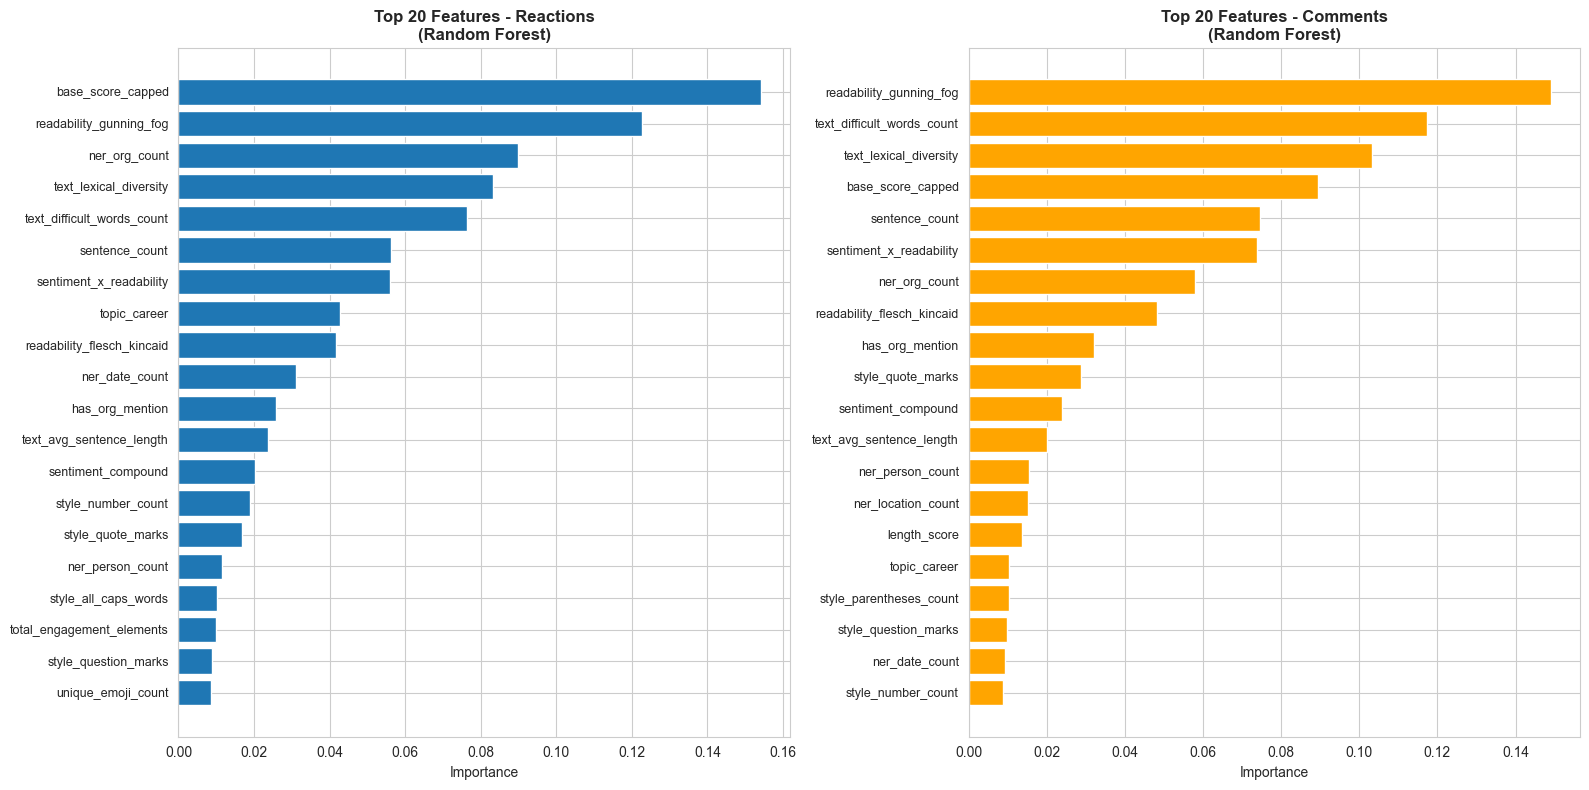


✓ Feature importance analysis complete


In [45]:
# Get feature importance from best tree-based models
if best_reactions in ['Random Forest', 'XGBoost', 'LightGBM']:
    importance_reactions = pd.DataFrame({
        'feature': numeric_features,
        'importance': models_reactions[best_reactions].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Features for Reactions ({best_reactions}):")
    print(importance_reactions.head(15).to_string(index=False))
else:
    print(f"\n{best_reactions} doesn't provide feature importances")
    importance_reactions = None

if best_comments in ['Random Forest', 'XGBoost', 'LightGBM']:
    importance_comments = pd.DataFrame({
        'feature': numeric_features,
        'importance': models_comments[best_comments].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Features for Comments ({best_comments}):")
    print(importance_comments.head(15).to_string(index=False))
else:
    print(f"\n{best_comments} doesn't provide feature importances")
    importance_comments = None

# Visualize if available
if importance_reactions is not None and importance_comments is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Reactions
    top20_r = importance_reactions.head(20).iloc[::-1]
    axes[0].barh(range(20), top20_r['importance'])
    axes[0].set_yticks(range(20))
    axes[0].set_yticklabels(top20_r['feature'], fontsize=9)
    axes[0].set_xlabel('Importance')
    axes[0].set_title(f'Top 20 Features - Reactions\n({best_reactions})', fontweight='bold')
    
    # Comments
    top20_c = importance_comments.head(20).iloc[::-1]
    axes[1].barh(range(20), top20_c['importance'], color='orange')
    axes[1].set_yticks(range(20))
    axes[1].set_yticklabels(top20_c['feature'], fontsize=9)
    axes[1].set_xlabel('Importance')
    axes[1].set_title(f'Top 20 Features - Comments\n({best_comments})', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("\n✓ Feature importance analysis complete")

## 12. Hyperparameter Tuning (Optional)

In [46]:
# Only tune if tree-based model is best
tune_enabled = True  # Set to False to skip tuning

if tune_enabled and best_reactions in ['Random Forest', 'XGBoost', 'LightGBM']:
    print("="*80)
    print(f"HYPERPARAMETER TUNING - {best_reactions}")
    print("="*80)
    
    if best_reactions == 'XGBoost':
        param_grid = {
            'n_estimators': [200, 300],
            'max_depth': [7, 10],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8, 1.0]
        }
        
        print("\nTuning XGBoost for Reactions...")
        grid_search_r = GridSearchCV(
            xgb.XGBRegressor(random_state=42, n_jobs=-1),
            param_grid,
            cv=3,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        grid_search_r.fit(X_train, y_reactions_train)
        
        print(f"\nBest params: {grid_search_r.best_params_}")
        y_pred = grid_search_r.predict(X_test)
        metrics = evaluate_model(y_reactions_test, y_pred, "XGBoost Tuned")
        print(f"Tuned Performance: R²={metrics['r2']:.4f}, MAE={metrics['mae']:.2f}, sMAPE={metrics['smape']:.2f}%")
        
        # Save tuned model
        models_reactions['XGBoost Tuned'] = grid_search_r.best_estimator_
        
        # Tune for comments
        print("\nTuning XGBoost for Comments...")
        grid_search_c = GridSearchCV(
            xgb.XGBRegressor(random_state=42, n_jobs=-1),
            param_grid,
            cv=3,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        grid_search_c.fit(X_train, y_comments_train)
        
        print(f"\nBest params: {grid_search_c.best_params_}")
        y_pred = grid_search_c.predict(X_test)
        metrics = evaluate_model(y_comments_test, y_pred, "XGBoost Tuned")
        print(f"Tuned Performance: R²={metrics['r2']:.4f}, MAE={metrics['mae']:.2f}, sMAPE={metrics['smape']:.2f}%")
        
        # Save tuned model
        models_comments['XGBoost Tuned'] = grid_search_c.best_estimator_
        
        print("\n✓ Hyperparameter tuning complete")
    else:
        print(f"Tuning not implemented for {best_reactions}")
else:
    print("Hyperparameter tuning skipped")
    print(f"Using default {best_reactions} and {best_comments} models")

HYPERPARAMETER TUNING - Random Forest
Tuning not implemented for Random Forest


## 13. Save Final Models

In [47]:
# Create models directory
MODEL_DIR = '../models_v3_fixed/'
import os
os.makedirs(MODEL_DIR, exist_ok=True)

# Determine which models to save
if 'XGBoost Tuned' in models_reactions:
    final_model_r = models_reactions['XGBoost Tuned']
    final_name_r = 'XGBoost Tuned'
else:
    final_model_r = models_reactions[best_reactions]
    final_name_r = best_reactions

if 'XGBoost Tuned' in models_comments:
    final_model_c = models_comments['XGBoost Tuned']
    final_name_c = 'XGBoost Tuned'
else:
    final_model_c = models_comments[best_comments]
    final_name_c = best_comments

# Save models
joblib.dump(final_model_r, f'{MODEL_DIR}reactions_model.pkl')
joblib.dump(final_model_c, f'{MODEL_DIR}comments_model.pkl')
joblib.dump(scaler, f'{MODEL_DIR}feature_scaler.pkl')

print(f"✓ Models saved to {MODEL_DIR}")
print(f"  - reactions_model.pkl ({final_name_r})")
print(f"  - comments_model.pkl ({final_name_c})")
print(f"  - feature_scaler.pkl")

# Save feature names
with open(f'{MODEL_DIR}feature_names.json', 'w') as f:
    json.dump({
        'features': numeric_features,
        'n_features': len(numeric_features),
        'excluded_leakage_features': LEAKAGE_FEATURES
    }, f, indent=2)

# Get final metrics
if final_name_r in ['Linear Regression', 'Ridge']:
    y_pred_r_final = final_model_r.predict(X_test_scaled)
else:
    y_pred_r_final = final_model_r.predict(X_test)

if final_name_c in ['Linear Regression', 'Ridge']:
    y_pred_c_final = final_model_c.predict(X_test_scaled)
else:
    y_pred_c_final = final_model_c.predict(X_test)

metrics_r = evaluate_model(y_reactions_test, y_pred_r_final, final_name_r)
metrics_c = evaluate_model(y_comments_test, y_pred_c_final, final_name_c)

# Save metadata
metadata = {
    'version': '2.0',
    'status': 'FIXED - No data leakage',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': {
        'total_samples': len(df),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'n_features': len(numeric_features),
        'excluded_leakage_features': LEAKAGE_FEATURES
    },
    'data_quality': {
        'reactions_zeros_pct': float(reactions_zeros/len(df)*100),
        'comments_zeros_pct': float(comments_zeros/len(df)*100)
    },
    'reactions_model': {
        'type': final_name_r,
        'performance': {
            'r2': float(metrics_r['r2']),
            'mae': float(metrics_r['mae']),
            'rmse': float(metrics_r['rmse']),
            'smape': float(metrics_r['smape']),
            'medae': float(metrics_r['medae'])
        }
    },
    'comments_model': {
        'type': final_name_c,
        'performance': {
            'r2': float(metrics_c['r2']),
            'mae': float(metrics_c['mae']),
            'rmse': float(metrics_c['rmse']),
            'smape': float(metrics_c['smape']),
            'medae': float(metrics_c['medae'])
        }
    },
    'fixes_applied': [
        'Removed data leakage features (reactions_per_word, comments_per_word, etc.)',
        'Replaced MAPE with sMAPE (handles zeros properly)',
        'Added cross-validation for robust evaluation',
        'Increased model regularization to prevent overfitting',
        'Added comprehensive data quality checks'
    ]
}

with open(f'{MODEL_DIR}model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Metadata saved")

print("\n" + "="*80)
print("SUCCESS: MODEL TRAINING V3 (FIXED) COMPLETE")
print("="*80)

print(f"\nFinal Model Performance (CLEAN DATA - NO LEAKAGE):")
print(f"\nReactions ({final_name_r}):")
print(f"  R²: {metrics_r['r2']:.4f}")
print(f"  MAE: {metrics_r['mae']:.2f}")
print(f"  RMSE: {metrics_r['rmse']:.2f}")
print(f"  sMAPE: {metrics_r['smape']:.2f}%")
print(f"  MedAE: {metrics_r['medae']:.2f}")

print(f"\nComments ({final_name_c}):")
print(f"  R²: {metrics_c['r2']:.4f}")
print(f"  MAE: {metrics_c['mae']:.2f}")
print(f"  RMSE: {metrics_c['rmse']:.2f}")
print(f"  sMAPE: {metrics_c['smape']:.2f}%")
print(f"  MedAE: {metrics_c['medae']:.2f}")

✓ Models saved to ../models_v3_fixed/
  - reactions_model.pkl (Random Forest)
  - comments_model.pkl (Random Forest)
  - feature_scaler.pkl
✓ Metadata saved

SUCCESS: MODEL TRAINING V3 (FIXED) COMPLETE

Final Model Performance (CLEAN DATA - NO LEAKAGE):

Reactions (Random Forest):
  R²: -0.1321
  MAE: 427.14
  RMSE: 712.54
  sMAPE: 131.73%
  MedAE: 252.78

Comments (Random Forest):
  R²: -0.0575
  MAE: 34.16
  RMSE: 52.27
  sMAPE: 131.37%
  MedAE: 24.41
